In [1]:
# Melakukan impor libraries yang diperlukan untuk membangun model dan prediksi data.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
import optuna
from optuna.samplers import TPESampler
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import random
import time
import datetime

In [2]:
# Mencatat waktu dimulainya keseluruhan program model dan prediksi data.
global_start_time = time.time()

In [3]:
# Menetapkan nilai seed untuk reproduksi model.
seed = 2021
def set_seed(seed = seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)

set_seed()

In [4]:
# Menentukan indeks fold, kode penamaan program, banyak epoch, dan ukuran batch.
fold_index = 0
codename = '1_04_01_{}'.format(fold_index)
epochs = 128
batch_size = 64

In [5]:
# Menyusun data training.
df_train = pd.read_csv('../input/bdc-sd2021-train-tabular-data/train_gray.csv')
fake_train = pd.DataFrame(np.array(df_train).reshape((2305, 128, 128))[:, :, ::-1].reshape((2305, 128*128)))
fake_train.columns = df_train.columns
df_train = pd.concat([df_train, fake_train], ignore_index = True)
del fake_train

# Menyusun data testing.
df_test = pd.read_csv('../input/bdc-sd2021-test-tabular-data/test_gray.csv')

In [6]:
# Melakukan normalisasi pada data training.
scaler = MinMaxScaler(copy = False)
scaler.fit_transform(df_train.T)
df_train

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.183857,0.139013,0.098655,0.116592,0.121076,0.103139,0.116592,0.094170,0.089686,0.076233,...,0.242152,0.089686,0.103139,0.121076,0.134529,0.156951,0.156951,0.156951,0.174888,0.152466
1,0.857868,0.857868,0.857868,0.857868,0.857868,0.857868,0.842640,0.827411,0.842640,0.827411,...,0.319797,0.294416,0.253807,0.208122,0.147208,0.116751,0.096447,0.065990,0.055838,0.040609
2,0.018182,0.013636,0.013636,0.018182,0.018182,0.018182,0.018182,0.018182,0.013636,0.018182,...,0.568182,0.559091,0.536364,0.518182,0.486364,0.436364,0.368182,0.254545,0.113636,0.045455
3,0.162500,0.162500,0.154167,0.154167,0.166667,0.187500,0.216667,0.254167,0.233333,0.183333,...,0.666667,0.675000,0.745833,0.887500,0.908333,0.900000,0.916667,0.945833,0.966667,0.966667
4,0.893023,0.860465,0.804651,0.879070,0.869767,0.637209,0.479070,0.269767,0.186047,0.186047,...,0.106977,0.032558,0.027907,0.018605,0.004651,0.000000,0.000000,0.004651,0.009302,0.018605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,0.090476,0.076190,0.095238,0.114286,0.090476,0.109524,0.076190,0.061905,0.052381,0.076190,...,0.157143,0.114286,0.133333,0.047619,0.061905,0.061905,0.052381,0.042857,0.042857,0.042857
4606,0.356828,0.370044,0.396476,0.409692,0.396476,0.422907,0.471366,0.515419,0.480176,0.436123,...,0.030837,0.035242,0.030837,0.026432,0.022026,0.017621,0.039648,0.026432,0.017621,0.035242
4607,0.306977,0.279070,0.339535,0.330233,0.320930,0.367442,0.367442,0.316279,0.283721,0.339535,...,0.060465,0.074419,0.065116,0.051163,0.051163,0.046512,0.083721,0.065116,0.055814,0.097674
4608,0.145000,0.240000,0.290000,0.295000,0.230000,0.170000,0.185000,0.200000,0.200000,0.230000,...,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.010000,0.010000,0.010000


In [7]:
# Melakukan normalisasi pada data testing.
scaler.fit_transform(df_test.T)
df_test

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.095238,0.100000,0.100000,0.095238,0.095238,0.100000,0.109524,0.114286,0.119048,0.104762,...,0.347619,0.361905,0.314286,0.400000,0.419048,0.261905,0.233333,0.300000,0.266667,0.257143
1,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.066116,0.066116,...,0.417355,0.322314,0.285124,0.471074,0.508264,0.475207,0.541322,0.644628,0.611570,0.512397
2,0.531120,0.493776,0.485477,0.427386,0.402490,0.356846,0.340249,0.356846,0.336100,0.340249,...,0.190871,0.112033,0.062241,0.058091,0.074689,0.066390,0.058091,0.053942,0.045643,0.053942
3,0.796703,0.796703,0.791209,0.791209,0.796703,0.818681,0.818681,0.785714,0.763736,0.763736,...,0.961538,0.950549,0.950549,0.945055,0.939560,0.928571,0.923077,0.917582,0.906593,0.879121
4,0.222222,0.232804,0.232804,0.248677,0.253968,0.259259,0.248677,0.243386,0.243386,0.243386,...,0.619048,0.613757,0.608466,0.608466,0.613757,0.592593,0.566138,0.502646,0.470899,0.449735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.828571,0.844898,0.804082,0.824490,0.918367,0.963265,0.987755,0.959184,0.873469,0.722449,...,0.857143,0.848980,0.828571,0.832653,0.840816,0.840816,0.816327,0.820408,0.783673,0.767347
986,0.048780,0.065041,0.077236,0.105691,0.117886,0.121951,0.126016,0.069106,0.060976,0.052846,...,0.186992,0.207317,0.223577,0.239837,0.260163,0.284553,0.304878,0.321138,0.337398,0.357724
987,0.056872,0.056872,0.061611,0.061611,0.071090,0.056872,0.037915,0.023697,0.009479,0.018957,...,0.900474,0.890995,0.895735,0.900474,0.895735,0.895735,0.890995,0.890995,0.890995,0.890995
988,0.109244,0.155462,0.168067,0.121849,0.113445,0.088235,0.079832,0.084034,0.079832,0.067227,...,0.525210,0.281513,0.050420,0.033613,0.037815,0.033613,0.033613,0.042017,0.042017,0.042017


In [8]:
# Memunculkan target prediksi.
target_0 = pd.read_csv('../input/bdc-sd2021-data-tambahan/train_target_and_fold.csv')[['usia', 'fold']]
target_1 = pd.concat([target_0 for iteration in range(2)], ignore_index = True)
target_1

,usia,fold
0,27,3
1,27,3
2,27,3
3,24,0
4,24,0
...,...,...
4605,23,4
4606,23,4
4607,27,4
4608,27,4


In [9]:
# Melakukan penambahan data training yang berkaitan dengan posisi relatif fitur pada wajah.
df_train_1 = pd.read_csv('../input/bdc-sd2021-data-tambahan/train_facial_relative.csv')
fake_train_1 = df_train_1.copy()
fake_train_1['x_le'] = 1 - df_train_1['x_re']
fake_train_1['x_re'] = 1 - df_train_1['x_le']
fake_train_1['x_n'] = 1 - df_train_1['x_n']
fake_train_1['x_ml'] = 1 - df_train_1['x_mr']
fake_train_1['x_mr'] = 1 - df_train_1['x_ml']
fake_train_1[['sym_le_n', 'adj_le_n', 'sym_re_n', 'adj_re_n']] = df_train_1[['sym_re_n', 'adj_re_n', 'sym_le_n', 'adj_le_n']]
fake_train_1[['sym_le_ml', 'adj_le_ml', 'sym_re_mr', 'adj_re_mr']] = df_train_1[['sym_re_mr', 'adj_re_mr', 'sym_le_ml', 'adj_le_ml']]
fake_train_1[['sym_le_mr', 'adj_le_mr', 'sym_re_ml', 'adj_re_ml']] = df_train_1[['sym_re_ml', 'adj_re_ml', 'sym_le_mr', 'adj_le_mr']]
fake_train_1[['sym_n_ml', 'adj_n_ml', 'sym_n_mr', 'adj_n_mr']] = df_train_1[['sym_n_mr', 'adj_n_mr', 'sym_n_ml', 'adj_n_ml']]

df_train_1 = pd.concat([df_train_1, fake_train_1], ignore_index = True)
del fake_train_1

df_train_1

,x_le,y_le,x_re,y_re,x_n,y_n,x_ml,y_ml,x_mr,y_mr,...,adj_n_ml,sym_le_mr,adj_le_mr,sym_re_mr,adj_re_mr,sym_n_mr,adj_n_mr,sym_ml_mr,adj_ml_mr,abs_angle
0,0.204545,0.390411,0.698052,0.392694,0.405844,0.618721,0.194805,0.712329,0.733766,0.705479,...,0.249515,0.615908,0.693416,0.314818,0.446237,0.339205,0.350364,0.539005,0.539049,0.061566
1,0.179724,0.397351,0.589862,0.403974,0.290323,0.619205,0.202765,0.725166,0.635945,0.728477,...,0.171500,0.563722,0.648461,0.327759,0.453958,0.362484,0.377599,0.433192,0.433204,0.134023
2,0.195946,0.404878,0.662162,0.404878,0.378378,0.614634,0.202703,0.731707,0.682432,0.731707,...,0.239078,0.586077,0.664537,0.327457,0.453156,0.325814,0.344595,0.479730,0.479730,0.174672
3,0.266055,0.373239,0.715596,0.373239,0.440367,0.549296,0.238532,0.690141,0.724771,0.704225,...,0.272772,0.565660,0.629561,0.331113,0.431290,0.323865,0.348745,0.486442,0.486585,0.121842
4,0.244565,0.389764,0.695652,0.393701,0.413043,0.578740,0.217391,0.696850,0.706522,0.712598,...,0.254682,0.563583,0.641880,0.319083,0.440352,0.322564,0.346806,0.489384,0.489613,0.012195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,0.362934,0.401146,0.803089,0.383954,0.660232,0.616046,0.389961,0.759312,0.737452,0.753582,...,0.327708,0.530242,0.629355,0.364131,0.487068,0.162752,0.207921,0.347538,0.347576,0.540420
4606,0.232323,0.386256,0.744108,0.398104,0.515152,0.649289,0.313131,0.772512,0.717172,0.779621,...,0.274054,0.612584,0.719783,0.387194,0.549482,0.236635,0.267332,0.404103,0.404167,0.552494
4607,0.274869,0.400372,0.759162,0.396648,0.523560,0.616387,0.324607,0.780261,0.685864,0.780261,...,0.304386,0.562206,0.678031,0.386895,0.539038,0.230645,0.281800,0.361257,0.361257,0.162489
4608,0.323887,0.405836,0.801619,0.413793,0.668016,0.631300,0.425101,0.801061,0.785425,0.814324,...,0.370196,0.602490,0.749939,0.395557,0.603456,0.206407,0.284469,0.360568,0.360892,0.456213


In [10]:
# Melakukan penambahan data testing yang berkaitan dengan posisi relatif fitur pada wajah.
df_test_1 = pd.read_csv('../input/bdc-sd2021-data-tambahan/test_facial_relative.csv')
df_test_1

,x_le,y_le,x_re,y_re,x_n,y_n,x_ml,y_ml,x_mr,y_mr,...,adj_n_ml,sym_le_mr,adj_le_mr,sym_re_mr,adj_re_mr,sym_n_mr,adj_n_mr,sym_ml_mr,adj_ml_mr,abs_angle
0,0.291209,0.333333,0.758242,0.338028,0.521978,0.516432,0.296703,0.732394,0.730769,0.737089,...,0.338570,0.596852,0.645365,0.400006,0.467840,0.303782,0.332088,0.434091,0.434101,0.070471
1,0.281690,0.405128,0.753521,0.394872,0.549296,0.625641,0.260563,0.723077,0.746479,0.707692,...,0.318229,0.554593,0.623428,0.312900,0.429635,0.213573,0.227106,0.486159,0.486375,0.029403
2,0.214533,0.403023,0.660900,0.397985,0.366782,0.612091,0.235294,0.727960,0.692042,0.722922,...,0.206456,0.574761,0.648943,0.326426,0.447452,0.343624,0.359129,0.456775,0.456800,0.022553
3,0.365517,0.391753,0.779310,0.402062,0.648276,0.597938,0.393103,0.773196,0.758621,0.757732,...,0.346547,0.537095,0.627927,0.356271,0.476312,0.194191,0.240590,0.365844,0.366102,0.064427
4,0.265625,0.381323,0.734375,0.369650,0.500000,0.603113,0.296875,0.747082,0.718750,0.735409,...,0.279993,0.575064,0.655712,0.366092,0.489833,0.255644,0.281443,0.422036,0.422164,0.044914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.356364,0.398892,0.821818,0.398892,0.650909,0.617729,0.374545,0.739612,0.785455,0.736842,...,0.319338,0.546195,0.617197,0.339901,0.445124,0.179696,0.206282,0.410918,0.410925,0.124355
986,0.274725,0.380952,0.758242,0.373016,0.582418,0.563492,0.362637,0.777778,0.747253,0.753968,...,0.369237,0.602016,0.700027,0.381111,0.527587,0.251896,0.311010,0.385352,0.386026,0.047583
987,0.289855,0.373737,0.753623,0.383838,0.521739,0.585859,0.275362,0.737374,0.724638,0.747475,...,0.328573,0.573337,0.690348,0.364790,0.522544,0.259399,0.308120,0.449389,0.449509,0.031240
988,0.142857,0.338403,0.614286,0.338403,0.319048,0.593156,0.200000,0.779468,0.557143,0.779468,...,0.261948,0.605120,0.690476,0.444751,0.555329,0.302327,0.333367,0.357143,0.357143,0.020199


In [11]:
# Menyusun indeks untuk data training dan melakukan shuffle.
train_index = list(target_1[target_1['fold'] != fold_index].index)
random.seed(seed)
random.shuffle(train_index)

# Menyusun indeks untuk data validasi.
valid_index = list(target_0[target_0['fold'] == fold_index].index)

# Memisahkan data validasi dari data training, serta menginisiasi data testing.
X_train = df_train.iloc[train_index]
X_valid = df_train.iloc[valid_index]
X_test = df_test.copy()

X_train_1 = df_train_1.iloc[train_index]
X_valid_1 = df_train_1.iloc[valid_index]
X_test_1 = df_test_1.copy()

# Melakukan reduksi dimensi dengan menggunakan PCA.
pca = PCA(0.95)
X_train = pd.DataFrame(pca.fit_transform(X_train))
X_valid = pd.DataFrame(pca.transform(X_valid))
X_test = pd.DataFrame(pca.transform(X_test))

pca = PCA(0.95)
X_train_1 = pd.DataFrame(pca.fit_transform(X_train_1))
X_valid_1 = pd.DataFrame(pca.transform(X_valid_1))
X_test_1 = pd.DataFrame(pca.transform(X_test_1))

# Menggabungkan informasi pada data training, validasi, dan testing.
X_train = pd.concat([X_train, X_train_1], axis = 1, ignore_index = True)
X_valid = pd.concat([X_valid, X_valid_1], axis = 1, ignore_index = True)
X_test = pd.concat([X_test, X_test_1], axis = 1, ignore_index = True)
del X_train_1, X_valid_1, X_test_1

# Mengubah ukuran data agar sesuai dengan input yang diharapkan oleh model.
X_train = X_train.values.reshape(-1, X_train.shape[1], 1).astype('float64')
X_valid = X_valid.values.reshape(-1, X_valid.shape[1], 1).astype('float64')
X_test = X_test.values.reshape(-1, X_test.shape[1], 1).astype('float64')

# Memisahkan target validasi dari target training.
y_train = target_1.iloc[train_index, 0].astype('int64')
y_valid = target_0.iloc[valid_index, 0].astype('int64')

# Membuang informasi yang sudah tidak diperlukan lagi.
del df_train, df_test, df_train_1, df_test_1, pca, target_0, target_1, train_index, valid_index

In [12]:
# Mendefinisikan fungsi untuk mencari parameter terbaik dengan nilai error terkecil.
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 5)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-3, log = True)
    dropout = trial.suggest_float('dropout', 0.2, 0.5, log = True)
    model = Sequential()
    for i in range(n_layers-1):
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 32, 256, log = True)
        if i:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(weight_decay)))
            model.add(Dropout(dropout))
        else:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(weight_decay),
                            input_shape = (X_train.shape[1], 1)))
    model.add(Flatten())
    num_hidden = trial.suggest_int('n_units_l{}'.format(n_layers-1), 32, 256, log = True)
    model.add(Dense(num_hidden,
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(1,
                    activation = 'linear',
                    kernel_regularizer = regularizers.l2(weight_decay)))
    return model

def create_optimizer(trial):
    kwargs = {}
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    if optimizer_selected == 'RMSprop':
        kwargs['learning_rate'] = trial.suggest_float(
            'rmsprop_learning_rate', 1e-5, 1e-1, log=True)
        kwargs['decay'] = trial.suggest_float('rmsprop_decay', 0.85, 0.99)
        kwargs['momentum'] = trial.suggest_float('rmsprop_momentum', 1e-5, 1e-1, log = True)
    elif optimizer_selected == 'Adam':
        kwargs['learning_rate'] = trial.suggest_float('adam_learning_rate', 1e-5, 1e-1, log = True)
    elif optimizer_selected == 'SGD':
        kwargs['learning_rate'] = trial.suggest_float(
            'sgd_opt_learning_rate', 1e-5, 1e-1, log=True)
        kwargs['momentum'] = trial.suggest_float('sgd_opt_momentum', 1e-5, 1e-1, log = True)
    
    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def objective(trial):
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mse'])
    set_seed()
    history = model.fit(X_train, y_train,
                        epochs = 3,
                        validation_data = (X_valid, y_valid),
                        verbose = 2,
                        steps_per_epoch = X_train.shape[0] // batch_size)
    y_valid_pred = model.predict(X_valid)
    try:
        mse = MSE(y_valid, y_valid_pred)
    except ValueError:
        mse = 1e+32
    return mse

In [13]:
# Mencari hyperparameters terbaik.
try:
    study = optuna.create_study(sampler = TPESampler(seed = seed), direction = 'minimize')
    study.optimize(objective, n_trials = 50)
except ValueError:
    pass

[I 2021-11-04 10:54:59,899] A new study created in memory with name: no-name-53e4a3a1-81c4-4115-9a05-b56a695298ed

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIN

Epoch 1/3
57/57 - 6s - loss: 631.9805 - mse: 631.9769 - val_loss: 432.7738 - val_mse: 432.7702
Epoch 2/3
57/57 - 4s - loss: 121.9161 - mse: 121.9125 - val_loss: 39.1022 - val_mse: 39.0986
Epoch 3/3
57/57 - 4s - loss: 39.4282 - mse: 39.4246 - val_loss: 37.0254 - val_mse: 37.0218


[I 2021-11-04 10:55:14,674] Trial 0 finished with value: 37.02178988751884 and parameters: {'n_layers': 4, 'weight_decay': 1.3601459990500093e-05, 'dropout': 0.22715517141780636, 'n_units_l0': 61, 'n_units_l1': 255, 'n_units_l2': 41, 'n_units_l3': 46, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 2.4410551066709827e-05, 'sgd_opt_momentum': 1.7150829926878746e-05}. Best is trial 0 with value: 37.02178988751884.


Epoch 1/3
57/57 - 10s - loss: 249.5610 - mse: 249.5599 - val_loss: 39.5740 - val_mse: 39.5728
Epoch 2/3
57/57 - 9s - loss: 36.4546 - mse: 36.4534 - val_loss: 35.6323 - val_mse: 35.6312
Epoch 3/3
57/57 - 9s - loss: 33.9419 - mse: 33.9407 - val_loss: 34.2731 - val_mse: 34.2720


[I 2021-11-04 10:55:42,895] Trial 1 finished with value: 34.27196049662438 and parameters: {'n_layers': 5, 'weight_decay': 2.069674778352553e-06, 'dropout': 0.2165227444547113, 'n_units_l0': 102, 'n_units_l1': 115, 'n_units_l2': 238, 'n_units_l3': 105, 'n_units_l4': 69, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 6.0309245793449296e-05, 'sgd_opt_momentum': 0.0021618027516387694}. Best is trial 1 with value: 34.27196049662438.


Epoch 1/3
57/57 - 3s - loss: 76.3010 - mse: 76.3008 - val_loss: 32.9582 - val_mse: 32.9580
Epoch 2/3
57/57 - 2s - loss: 30.4234 - mse: 30.4232 - val_loss: 28.1503 - val_mse: 28.1501
Epoch 3/3
57/57 - 2s - loss: 26.8565 - mse: 26.8563 - val_loss: 28.7149 - val_mse: 28.7147


[I 2021-11-04 10:55:50,086] Trial 2 finished with value: 28.714712291905055 and parameters: {'n_layers': 3, 'weight_decay': 4.2140608469491625e-07, 'dropout': 0.425181023662834, 'n_units_l0': 146, 'n_units_l1': 36, 'n_units_l2': 129, 'optimizer': 'Adam', 'adam_learning_rate': 0.0029509089780652155}. Best is trial 2 with value: 28.714712291905055.


Epoch 1/3
57/57 - 7s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/3
57/57 - 6s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/3
57/57 - 6s - loss: nan - mse: nan - val_loss: nan - val_mse: nan


[I 2021-11-04 10:56:10,190] Trial 3 finished with value: 1e+32 and parameters: {'n_layers': 4, 'weight_decay': 1.280797128821542e-08, 'dropout': 0.4445600696908863, 'n_units_l0': 108, 'n_units_l1': 247, 'n_units_l2': 80, 'n_units_l3': 41, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.006855869932485577, 'sgd_opt_momentum': 0.03652763447965056}. Best is trial 2 with value: 28.714712291905055.


Epoch 1/3
57/57 - 4s - loss: 151.3745 - mse: 151.3738 - val_loss: 36.0831 - val_mse: 36.0823
Epoch 2/3
57/57 - 3s - loss: 34.7333 - mse: 34.7326 - val_loss: 38.4747 - val_mse: 38.4740
Epoch 3/3
57/57 - 3s - loss: 32.4348 - mse: 32.4341 - val_loss: 35.6310 - val_mse: 35.6303


[I 2021-11-04 10:56:20,299] Trial 4 finished with value: 35.6303068268018 and parameters: {'n_layers': 4, 'weight_decay': 2.869521426120942e-06, 'dropout': 0.2736582989224417, 'n_units_l0': 177, 'n_units_l1': 60, 'n_units_l2': 60, 'n_units_l3': 48, 'optimizer': 'Adam', 'adam_learning_rate': 0.0003587550277569686}. Best is trial 2 with value: 28.714712291905055.


Epoch 1/3
57/57 - 5s - loss: 2065956608.0000 - mse: 412045.4062 - val_loss: 2222974976.0000 - val_mse: 1346.7308
Epoch 2/3
57/57 - 4s - loss: 2222694400.0000 - mse: 457.0128 - val_loss: 2222403072.0000 - val_mse: 95.0377
Epoch 3/3
57/57 - 4s - loss: 2222123264.0000 - mse: 49.2893 - val_loss: 2221831936.0000 - val_mse: 31.7322


[I 2021-11-04 10:56:34,601] Trial 5 finished with value: 31.732215783210204 and parameters: {'n_layers': 4, 'weight_decay': 8.671491605192508e-05, 'dropout': 0.2120474687506201, 'n_units_l0': 75, 'n_units_l1': 63, 'n_units_l2': 143, 'n_units_l3': 85, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.012820573397259222, 'sgd_opt_momentum': 0.01219735525440408}. Best is trial 2 with value: 28.714712291905055.


Epoch 1/3
57/57 - 2s - loss: 93.9358 - mse: 93.9356 - val_loss: 53.0189 - val_mse: 53.0187
Epoch 2/3
57/57 - 1s - loss: 46.8588 - mse: 46.8586 - val_loss: 42.8495 - val_mse: 42.8493
Epoch 3/3
57/57 - 1s - loss: 42.6458 - mse: 42.6456 - val_loss: 40.2178 - val_mse: 40.2176


[I 2021-11-04 10:56:38,613] Trial 6 finished with value: 40.217617781868825 and parameters: {'n_layers': 2, 'weight_decay': 1.4490033299339797e-06, 'dropout': 0.4134236878013778, 'n_units_l0': 56, 'n_units_l1': 69, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0004666904757351211, 'rmsprop_decay': 0.894925822839254, 'rmsprop_momentum': 0.000308450498248823}. Best is trial 2 with value: 28.714712291905055.


Epoch 1/3
57/57 - 4s - loss: 59533.3789 - mse: 59533.3711 - val_loss: 95.1776 - val_mse: 95.1593
Epoch 2/3
57/57 - 3s - loss: 147.0010 - mse: 146.9827 - val_loss: 62.0804 - val_mse: 62.0621
Epoch 3/3
57/57 - 3s - loss: 93.8986 - mse: 93.8804 - val_loss: 49.1213 - val_mse: 49.1031


[I 2021-11-04 10:56:49,372] Trial 7 finished with value: 49.103136288689086 and parameters: {'n_layers': 3, 'weight_decay': 5.713328696681321e-06, 'dropout': 0.3407865362809055, 'n_units_l0': 241, 'n_units_l1': 75, 'n_units_l2': 63, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.019638650422524002, 'rmsprop_decay': 0.9279674621367233, 'rmsprop_momentum': 0.007481765717358807}. Best is trial 2 with value: 28.714712291905055.


Epoch 1/3
57/57 - 6s - loss: 586787.8750 - mse: 586787.8750 - val_loss: 45.7197 - val_mse: 45.7190
Epoch 2/3
57/57 - 5s - loss: 329.1953 - mse: 329.1946 - val_loss: 460.3760 - val_mse: 460.3753
Epoch 3/3
57/57 - 5s - loss: 60.0046 - mse: 60.0038 - val_loss: 584.3928 - val_mse: 584.3922


[I 2021-11-04 10:57:05,412] Trial 8 finished with value: 584.3921793117908 and parameters: {'n_layers': 5, 'weight_decay': 2.9653117862224153e-07, 'dropout': 0.3197493177048565, 'n_units_l0': 123, 'n_units_l1': 65, 'n_units_l2': 116, 'n_units_l3': 83, 'n_units_l4': 41, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.019054962911205356, 'rmsprop_decay': 0.874518227528278, 'rmsprop_momentum': 8.371297680962848e-05}. Best is trial 2 with value: 28.714712291905055.


Epoch 1/3
57/57 - 10s - loss: 2924.2290 - mse: 2924.2068 - val_loss: 46.9445 - val_mse: 46.9228
Epoch 2/3
57/57 - 9s - loss: 44.9517 - mse: 44.9300 - val_loss: 48.9451 - val_mse: 48.9234
Epoch 3/3
57/57 - 9s - loss: 41.4891 - mse: 41.4674 - val_loss: 50.6108 - val_mse: 50.5891


[I 2021-11-04 10:57:34,081] Trial 9 finished with value: 50.58907681626543 and parameters: {'n_layers': 4, 'weight_decay': 1.0556840099451229e-05, 'dropout': 0.22909938508654398, 'n_units_l0': 72, 'n_units_l1': 170, 'n_units_l2': 172, 'n_units_l3': 167, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.005553572385099785, 'rmsprop_decay': 0.9526963318618572, 'rmsprop_momentum': 3.908613352528237e-05}. Best is trial 2 with value: 28.714712291905055.


Epoch 1/3
57/57 - 1s - loss: 2722.4336 - mse: 2722.4331 - val_loss: 653.4010 - val_mse: 653.4001
Epoch 2/3
57/57 - 0s - loss: 594.8613 - mse: 594.8604 - val_loss: 539.0598 - val_mse: 539.0588
Epoch 3/3
57/57 - 0s - loss: 481.1167 - mse: 481.1158 - val_loss: 428.4093 - val_mse: 428.4083


[I 2021-11-04 10:57:36,411] Trial 10 finished with value: 428.408237263743 and parameters: {'n_layers': 2, 'weight_decay': 1.5303673965817338e-08, 'dropout': 0.36337622618058174, 'n_units_l0': 37, 'n_units_l1': 38, 'optimizer': 'Adam', 'adam_learning_rate': 0.07687620678695332}. Best is trial 2 with value: 28.714712291905055.


Epoch 1/3
57/57 - 3s - loss: 68.4665 - mse: 67.1793 - val_loss: 32.5214 - val_mse: 31.0822
Epoch 2/3
57/57 - 2s - loss: 31.0920 - mse: 29.8105 - val_loss: 29.9208 - val_mse: 28.7815
Epoch 3/3
57/57 - 2s - loss: 28.6899 - mse: 27.6348 - val_loss: 30.1458 - val_mse: 29.1660


[I 2021-11-04 10:57:44,345] Trial 11 finished with value: 29.165961369001575 and parameters: {'n_layers': 3, 'weight_decay': 0.0008338016434700748, 'dropout': 0.49767481025136756, 'n_units_l0': 155, 'n_units_l1': 34, 'n_units_l2': 130, 'optimizer': 'Adam', 'adam_learning_rate': 0.009062730720066392}. Best is trial 2 with value: 28.714712291905055.


Epoch 1/3
57/57 - 3s - loss: 245.1576 - mse: 243.5074 - val_loss: 32.4874 - val_mse: 30.5341
Epoch 2/3
57/57 - 2s - loss: 31.9305 - mse: 30.1829 - val_loss: 29.6411 - val_mse: 28.0882
Epoch 3/3
57/57 - 2s - loss: 31.8450 - mse: 30.4343 - val_loss: 29.2003 - val_mse: 27.9213


[I 2021-11-04 10:57:51,081] Trial 12 finished with value: 27.921277833755727 and parameters: {'n_layers': 3, 'weight_decay': 0.0009316945324941113, 'dropout': 0.4942740538589664, 'n_units_l0': 161, 'n_units_l1': 34, 'n_units_l2': 107, 'optimizer': 'Adam', 'adam_learning_rate': 0.010412299178528817}. Best is trial 12 with value: 27.921277833755727.


Epoch 1/3
57/57 - 3s - loss: 70.3115 - mse: 70.3115 - val_loss: 31.4408 - val_mse: 31.4408
Epoch 2/3
57/57 - 2s - loss: 28.1363 - mse: 28.1363 - val_loss: 29.5523 - val_mse: 29.5523
Epoch 3/3
57/57 - 2s - loss: 27.6773 - mse: 27.6773 - val_loss: 29.5879 - val_mse: 29.5879


[I 2021-11-04 10:57:59,502] Trial 13 finished with value: 29.587869896346913 and parameters: {'n_layers': 3, 'weight_decay': 1.991247839884373e-10, 'dropout': 0.49611215443722484, 'n_units_l0': 255, 'n_units_l1': 45, 'n_units_l2': 87, 'optimizer': 'Adam', 'adam_learning_rate': 0.004142797367627817}. Best is trial 12 with value: 27.921277833755727.


Epoch 1/3
57/57 - 2s - loss: 382.9616 - mse: 382.8761 - val_loss: 152.8582 - val_mse: 152.7712
Epoch 2/3
57/57 - 2s - loss: 74.3260 - mse: 74.2371 - val_loss: 41.8438 - val_mse: 41.7533
Epoch 3/3
57/57 - 2s - loss: 39.7787 - mse: 39.6878 - val_loss: 36.7911 - val_mse: 36.6999


[I 2021-11-04 10:58:05,199] Trial 14 finished with value: 36.6998889809962 and parameters: {'n_layers': 2, 'weight_decay': 0.0008544832045566893, 'dropout': 0.4109404978407691, 'n_units_l0': 165, 'n_units_l1': 47, 'optimizer': 'Adam', 'adam_learning_rate': 3.1014013106972164e-05}. Best is trial 12 with value: 27.921277833755727.


Epoch 1/3
57/57 - 3s - loss: 85.0195 - mse: 85.0194 - val_loss: 34.3761 - val_mse: 34.3761
Epoch 2/3
57/57 - 2s - loss: 32.1213 - mse: 32.1213 - val_loss: 30.0093 - val_mse: 30.0093
Epoch 3/3
57/57 - 2s - loss: 28.0183 - mse: 28.0183 - val_loss: 29.0360 - val_mse: 29.0360


[I 2021-11-04 10:58:12,074] Trial 15 finished with value: 29.036020254905083 and parameters: {'n_layers': 3, 'weight_decay': 3.032810312970203e-08, 'dropout': 0.3815955695340615, 'n_units_l0': 135, 'n_units_l1': 32, 'n_units_l2': 202, 'optimizer': 'Adam', 'adam_learning_rate': 0.0012013708276208072}. Best is trial 12 with value: 27.921277833755727.


Epoch 1/3
57/57 - 3s - loss: 4671.2402 - mse: 4671.2402 - val_loss: 27.7789 - val_mse: 27.7789
Epoch 2/3
57/57 - 2s - loss: 30.1139 - mse: 30.1139 - val_loss: 27.7447 - val_mse: 27.7447
Epoch 3/3
57/57 - 2s - loss: 29.0744 - mse: 29.0744 - val_loss: 30.9217 - val_mse: 30.9217


[I 2021-11-04 10:58:19,980] Trial 16 finished with value: 30.921706644018787 and parameters: {'n_layers': 3, 'weight_decay': 1.1811363658965055e-10, 'dropout': 0.45299317042843545, 'n_units_l0': 190, 'n_units_l1': 47, 'n_units_l2': 108, 'optimizer': 'Adam', 'adam_learning_rate': 0.03750139275787095}. Best is trial 12 with value: 27.921277833755727.


Epoch 1/3
57/57 - 4s - loss: 70.5149 - mse: 70.4942 - val_loss: 35.9115 - val_mse: 35.8896
Epoch 2/3
57/57 - 3s - loss: 32.7806 - mse: 32.7584 - val_loss: 34.3936 - val_mse: 34.3710
Epoch 3/3
57/57 - 4s - loss: 30.6695 - mse: 30.6463 - val_loss: 34.4213 - val_mse: 34.3975


[I 2021-11-04 10:58:31,549] Trial 17 finished with value: 34.397512789092694 and parameters: {'n_layers': 2, 'weight_decay': 8.234843066168191e-05, 'dropout': 0.27353407809110303, 'n_units_l0': 213, 'n_units_l1': 98, 'optimizer': 'Adam', 'adam_learning_rate': 0.0007208519843444955}. Best is trial 12 with value: 27.921277833755727.


Epoch 1/3
57/57 - 6s - loss: 126.5842 - mse: 126.5842 - val_loss: 31.2076 - val_mse: 31.2076
Epoch 2/3
57/57 - 5s - loss: 27.9617 - mse: 27.9617 - val_loss: 27.7690 - val_mse: 27.7690
Epoch 3/3
57/57 - 6s - loss: 27.3087 - mse: 27.3086 - val_loss: 27.3202 - val_mse: 27.3202


[I 2021-11-04 10:58:49,742] Trial 18 finished with value: 27.320157399363325 and parameters: {'n_layers': 3, 'weight_decay': 2.7084578048322714e-09, 'dropout': 0.4354074667103928, 'n_units_l0': 140, 'n_units_l1': 131, 'n_units_l2': 162, 'optimizer': 'Adam', 'adam_learning_rate': 0.008446145801551484}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 3s - loss: 942.8757 - mse: 942.8757 - val_loss: 683.4777 - val_mse: 683.4776
Epoch 2/3
57/57 - 2s - loss: 660.3157 - mse: 660.3157 - val_loss: 642.8516 - val_mse: 642.8516
Epoch 3/3
57/57 - 2s - loss: 619.8034 - mse: 619.8034 - val_loss: 602.6088 - val_mse: 602.6088


[I 2021-11-04 10:58:56,334] Trial 19 finished with value: 602.6087476427476 and parameters: {'n_layers': 2, 'weight_decay': 2.3558618862053574e-09, 'dropout': 0.4696440247450452, 'n_units_l0': 90, 'n_units_l1': 132, 'optimizer': 'Adam', 'adam_learning_rate': 0.016003032784814655}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 8s - loss: 142.3489 - mse: 142.3489 - val_loss: 40.5747 - val_mse: 40.5747
Epoch 2/3
57/57 - 7s - loss: 38.1741 - mse: 38.1741 - val_loss: 35.2396 - val_mse: 35.2396
Epoch 3/3
57/57 - 7s - loss: 35.7652 - mse: 35.7652 - val_loss: 34.1196 - val_mse: 34.1196


[I 2021-11-04 10:59:18,555] Trial 20 finished with value: 34.11960683250907 and parameters: {'n_layers': 3, 'weight_decay': 9.971339084246419e-10, 'dropout': 0.3816599353210121, 'n_units_l0': 114, 'n_units_l1': 180, 'n_units_l2': 173, 'optimizer': 'Adam', 'adam_learning_rate': 9.748893009494004e-05}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 5s - loss: 113.5088 - mse: 113.5086 - val_loss: 36.6043 - val_mse: 36.6041
Epoch 2/3
57/57 - 4s - loss: 29.7966 - mse: 29.7964 - val_loss: 28.3952 - val_mse: 28.3949
Epoch 3/3
57/57 - 4s - loss: 26.7130 - mse: 26.7128 - val_loss: 27.6368 - val_mse: 27.6365


[I 2021-11-04 10:59:31,281] Trial 21 finished with value: 27.63652273071942 and parameters: {'n_layers': 3, 'weight_decay': 1.5875527098229412e-07, 'dropout': 0.41551967522517597, 'n_units_l0': 149, 'n_units_l1': 87, 'n_units_l2': 148, 'optimizer': 'Adam', 'adam_learning_rate': 0.00436748582451496}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 7s - loss: 356.3279 - mse: 356.3262 - val_loss: 29.2424 - val_mse: 29.2400
Epoch 2/3
57/57 - 6s - loss: 27.6461 - mse: 27.6436 - val_loss: 28.1655 - val_mse: 28.1630
Epoch 3/3
57/57 - 6s - loss: 27.8288 - mse: 27.8263 - val_loss: 30.9415 - val_mse: 30.9390


[I 2021-11-04 10:59:52,021] Trial 22 finished with value: 30.93902122396233 and parameters: {'n_layers': 3, 'weight_decay': 8.99879863068907e-08, 'dropout': 0.4054087549827675, 'n_units_l0': 203, 'n_units_l1': 144, 'n_units_l2': 163, 'optimizer': 'Adam', 'adam_learning_rate': 0.013430606902861594}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 4s - loss: 62.4277 - mse: 62.4277 - val_loss: 32.5530 - val_mse: 32.5530
Epoch 2/3
57/57 - 3s - loss: 28.4434 - mse: 28.4434 - val_loss: 29.9442 - val_mse: 29.9442
Epoch 3/3
57/57 - 3s - loss: 26.8722 - mse: 26.8722 - val_loss: 29.4176 - val_mse: 29.4176


[I 2021-11-04 11:00:03,234] Trial 23 finished with value: 29.417619093207083 and parameters: {'n_layers': 3, 'weight_decay': 2.678519869566393e-09, 'dropout': 0.28805186382752124, 'n_units_l0': 136, 'n_units_l1': 89, 'n_units_l2': 99, 'optimizer': 'Adam', 'adam_learning_rate': 0.0033365350500803087}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 14s - loss: 11180.6836 - mse: 11180.6602 - val_loss: 705.4277 - val_mse: 705.3965
Epoch 2/3
57/57 - 13s - loss: 691.3522 - mse: 691.3211 - val_loss: 682.5281 - val_mse: 682.4968
Epoch 3/3
57/57 - 13s - loss: 665.7532 - mse: 665.7218 - val_loss: 654.4709 - val_mse: 654.4395


[I 2021-11-04 11:00:43,859] Trial 24 finished with value: 654.4395449196077 and parameters: {'n_layers': 4, 'weight_decay': 9.901923430976877e-08, 'dropout': 0.467897279541026, 'n_units_l0': 164, 'n_units_l1': 87, 'n_units_l2': 244, 'n_units_l3': 255, 'optimizer': 'Adam', 'adam_learning_rate': 0.025819626104366493}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 6s - loss: 90.5823 - mse: 90.5823 - val_loss: 33.1708 - val_mse: 33.1708
Epoch 2/3
57/57 - 5s - loss: 27.5512 - mse: 27.5512 - val_loss: 28.1176 - val_mse: 28.1176
Epoch 3/3
57/57 - 5s - loss: 26.7952 - mse: 26.7951 - val_loss: 27.8184 - val_mse: 27.8184


[I 2021-11-04 11:01:00,028] Trial 25 finished with value: 27.818381581153407 and parameters: {'n_layers': 3, 'weight_decay': 6.926160267996678e-10, 'dropout': 0.3612477775668376, 'n_units_l0': 94, 'n_units_l1': 197, 'n_units_l2': 72, 'optimizer': 'Adam', 'adam_learning_rate': 0.00679467641786644}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 4s - loss: 68.0982 - mse: 68.0982 - val_loss: 36.1006 - val_mse: 36.1006
Epoch 2/3
57/57 - 3s - loss: 32.8688 - mse: 32.8688 - val_loss: 36.3652 - val_mse: 36.3652
Epoch 3/3
57/57 - 3s - loss: 30.6014 - mse: 30.6014 - val_loss: 34.6015 - val_mse: 34.6015


[I 2021-11-04 11:01:09,301] Trial 26 finished with value: 34.601479918938104 and parameters: {'n_layers': 2, 'weight_decay': 8.886823862078131e-10, 'dropout': 0.33632935059570634, 'n_units_l0': 89, 'n_units_l1': 214, 'optimizer': 'Adam', 'adam_learning_rate': 0.001602602289653997}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 4s - loss: 49.8772 - mse: 49.8772 - val_loss: 29.1570 - val_mse: 29.1570
Epoch 2/3
57/57 - 3s - loss: 27.6979 - mse: 27.6979 - val_loss: 29.1173 - val_mse: 29.1173
Epoch 3/3
57/57 - 3s - loss: 25.7942 - mse: 25.7942 - val_loss: 30.0067 - val_mse: 30.0067


[I 2021-11-04 11:01:19,796] Trial 27 finished with value: 30.00670651274877 and parameters: {'n_layers': 3, 'weight_decay': 5.206079566231821e-09, 'dropout': 0.3647707874853365, 'n_units_l0': 94, 'n_units_l1': 120, 'n_units_l2': 69, 'optimizer': 'Adam', 'adam_learning_rate': 0.005781671232855504}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 4s - loss: 700.5955 - mse: 700.5955 - val_loss: 704.1943 - val_mse: 704.1943
Epoch 2/3
57/57 - 3s - loss: 699.4062 - mse: 699.4062 - val_loss: 703.6353 - val_mse: 703.6353
Epoch 3/3
57/57 - 4s - loss: 698.7861 - mse: 698.7861 - val_loss: 703.3065 - val_mse: 703.3065


[I 2021-11-04 11:01:32,081] Trial 28 finished with value: 703.3066008926004 and parameters: {'n_layers': 4, 'weight_decay': 3.0870632309400095e-10, 'dropout': 0.29940717923314875, 'n_units_l0': 77, 'n_units_l1': 177, 'n_units_l2': 32, 'n_units_l3': 33, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.5460359877546164e-05, 'rmsprop_decay': 0.9889890813122181, 'rmsprop_momentum': 0.023156502810137904}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 9s - loss: nan - mse: inf - val_loss: nan - val_mse: 427400536394143235938361278464.0000
Epoch 2/3
57/57 - 8s - loss: nan - mse: 23879080578346785030413484032.0000 - val_loss: nan - val_mse: 177292467658880450560.0000
Epoch 3/3
57/57 - 8s - loss: nan - mse: 9905422189308411904.0000 - val_loss: nan - val_mse: 73543434240.0000


[I 2021-11-04 11:01:57,729] Trial 29 finished with value: 73543427644.2916 and parameters: {'n_layers': 5, 'weight_decay': 6.669935007973927e-10, 'dropout': 0.39024414604228347, 'n_units_l0': 37, 'n_units_l1': 145, 'n_units_l2': 53, 'n_units_l3': 142, 'n_units_l4': 256, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.08631186468037616, 'sgd_opt_momentum': 2.3566982169933773e-05}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 3s - loss: 77.2916 - mse: 77.2916 - val_loss: 36.2850 - val_mse: 36.2850
Epoch 2/3
57/57 - 2s - loss: 32.6905 - mse: 32.6905 - val_loss: 32.7966 - val_mse: 32.7966
Epoch 3/3
57/57 - 2s - loss: 29.6801 - mse: 29.6801 - val_loss: 30.3249 - val_mse: 30.3249


[I 2021-11-04 11:02:04,420] Trial 30 finished with value: 30.3248667127996 and parameters: {'n_layers': 2, 'weight_decay': 3.214996349809071e-08, 'dropout': 0.3531796706333548, 'n_units_l0': 54, 'n_units_l1': 213, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0003959502675922957, 'sgd_opt_momentum': 0.000272368752504295}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 4s - loss: 75.4580 - mse: 75.2477 - val_loss: 29.9096 - val_mse: 29.6385
Epoch 2/3
57/57 - 3s - loss: 27.7547 - mse: 27.4890 - val_loss: 28.1515 - val_mse: 27.8924
Epoch 3/3
57/57 - 3s - loss: 27.5278 - mse: 27.2713 - val_loss: 30.4531 - val_mse: 30.2012


[I 2021-11-04 11:02:15,601] Trial 31 finished with value: 30.2012452520069 and parameters: {'n_layers': 3, 'weight_decay': 8.236215925923027e-05, 'dropout': 0.4497630091538812, 'n_units_l0': 125, 'n_units_l1': 106, 'n_units_l2': 83, 'optimizer': 'Adam', 'adam_learning_rate': 0.008275073200806215}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 7s - loss: 10212.8564 - mse: 10212.8008 - val_loss: 31.1855 - val_mse: 31.1069
Epoch 2/3
57/57 - 6s - loss: 29.9391 - mse: 29.8604 - val_loss: 28.5634 - val_mse: 28.4851
Epoch 3/3
57/57 - 6s - loss: 29.6176 - mse: 29.5396 - val_loss: 31.4317 - val_mse: 31.3541


[I 2021-11-04 11:02:35,015] Trial 32 finished with value: 31.354117370617622 and parameters: {'n_layers': 3, 'weight_decay': 5.831606164067599e-07, 'dropout': 0.4207014807104092, 'n_units_l0': 144, 'n_units_l1': 156, 'n_units_l2': 154, 'optimizer': 'Adam', 'adam_learning_rate': 0.028952419425028388}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 5s - loss: 62.0491 - mse: 62.0491 - val_loss: 31.6142 - val_mse: 31.6142
Epoch 2/3
57/57 - 4s - loss: 27.8127 - mse: 27.8127 - val_loss: 27.4352 - val_mse: 27.4352
Epoch 3/3
57/57 - 4s - loss: 25.4045 - mse: 25.4045 - val_loss: 27.3875 - val_mse: 27.3875


[I 2021-11-04 11:02:47,680] Trial 33 finished with value: 27.38748546944826 and parameters: {'n_layers': 3, 'weight_decay': 4.8387693570486794e-09, 'dropout': 0.43349559269263743, 'n_units_l0': 109, 'n_units_l1': 121, 'n_units_l2': 103, 'optimizer': 'Adam', 'adam_learning_rate': 0.0023446936828748206}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 6s - loss: 89.9061 - mse: 89.9061 - val_loss: 38.1311 - val_mse: 38.1311
Epoch 2/3
57/57 - 5s - loss: 35.8590 - mse: 35.8590 - val_loss: 34.0164 - val_mse: 34.0164
Epoch 3/3
57/57 - 5s - loss: 32.1974 - mse: 32.1974 - val_loss: 32.6218 - val_mse: 32.6218


[I 2021-11-04 11:03:03,051] Trial 34 finished with value: 32.62177002859262 and parameters: {'n_layers': 3, 'weight_decay': 6.454203794349295e-09, 'dropout': 0.43431341198035994, 'n_units_l0': 101, 'n_units_l1': 113, 'n_units_l2': 203, 'optimizer': 'Adam', 'adam_learning_rate': 0.00032363747736007843}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 4s - loss: 79.4618 - mse: 79.4618 - val_loss: 32.3770 - val_mse: 32.3770
Epoch 2/3
57/57 - 3s - loss: 31.8994 - mse: 31.8994 - val_loss: 30.1279 - val_mse: 30.1279
Epoch 3/3
57/57 - 3s - loss: 30.7070 - mse: 30.7070 - val_loss: 28.7828 - val_mse: 28.7828


[I 2021-11-04 11:03:13,149] Trial 35 finished with value: 28.78283474140013 and parameters: {'n_layers': 3, 'weight_decay': 3.126807675793763e-09, 'dropout': 0.3940257263553661, 'n_units_l0': 111, 'n_units_l1': 77, 'n_units_l2': 130, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.00039317865777194303, 'sgd_opt_momentum': 0.0003701559733518888}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 6s - loss: 62.9822 - mse: 62.9822 - val_loss: 87.9662 - val_mse: 87.9662
Epoch 2/3
57/57 - 5s - loss: 28.5628 - mse: 28.5628 - val_loss: 63.1174 - val_mse: 63.1174
Epoch 3/3
57/57 - 5s - loss: 28.1707 - mse: 28.1707 - val_loss: 43.8264 - val_mse: 43.8264


[I 2021-11-04 11:03:30,655] Trial 36 finished with value: 43.82641135211147 and parameters: {'n_layers': 4, 'weight_decay': 4.927240546212767e-10, 'dropout': 0.4362677282256932, 'n_units_l0': 86, 'n_units_l1': 127, 'n_units_l2': 72, 'n_units_l3': 249, 'optimizer': 'Adam', 'adam_learning_rate': 0.002463984405705493}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 3s - loss: 80.7871 - mse: 80.7871 - val_loss: 36.3005 - val_mse: 36.3005
Epoch 2/3
57/57 - 2s - loss: 32.7357 - mse: 32.7356 - val_loss: 31.1941 - val_mse: 31.1941
Epoch 3/3
57/57 - 2s - loss: 28.5360 - mse: 28.5360 - val_loss: 30.3931 - val_mse: 30.3931


[I 2021-11-04 11:03:38,047] Trial 37 finished with value: 30.393067882682377 and parameters: {'n_layers': 3, 'weight_decay': 1.0633708031456913e-07, 'dropout': 0.3225718526790159, 'n_units_l0': 63, 'n_units_l1': 100, 'n_units_l2': 48, 'optimizer': 'Adam', 'adam_learning_rate': 0.0011712743825901524}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 7s - loss: 650.2635 - mse: 650.2635 - val_loss: 567.7005 - val_mse: 567.7005
Epoch 2/3
57/57 - 6s - loss: 372.9629 - mse: 372.9629 - val_loss: 167.5465 - val_mse: 167.5465
Epoch 3/3
57/57 - 6s - loss: 67.9424 - mse: 67.9424 - val_loss: 45.8873 - val_mse: 45.8873


[I 2021-11-04 11:03:58,260] Trial 38 finished with value: 45.88728652695702 and parameters: {'n_layers': 4, 'weight_decay': 1.1052151804919244e-08, 'dropout': 0.36212392756207273, 'n_units_l0': 122, 'n_units_l1': 207, 'n_units_l2': 98, 'n_units_l3': 59, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 1.0521502434471018e-05, 'sgd_opt_momentum': 0.0815326847765571}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 10s - loss: 73.4633 - mse: 73.4633 - val_loss: 36.8772 - val_mse: 36.8772
Epoch 2/3
57/57 - 10s - loss: 33.1511 - mse: 33.1511 - val_loss: 32.4914 - val_mse: 32.4914
Epoch 3/3
57/57 - 10s - loss: 28.7187 - mse: 28.7187 - val_loss: 30.2807 - val_mse: 30.2807


[I 2021-11-04 11:04:28,837] Trial 39 finished with value: 30.280688318533233 and parameters: {'n_layers': 3, 'weight_decay': 2.051228346892341e-09, 'dropout': 0.4686010798861611, 'n_units_l0': 101, 'n_units_l1': 243, 'n_units_l2': 202, 'optimizer': 'Adam', 'adam_learning_rate': 0.0004500107003161877}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 2s - loss: 634.1060 - mse: 634.1060 - val_loss: 626.9202 - val_mse: 626.9202
Epoch 2/3
57/57 - 1s - loss: 618.9454 - mse: 618.9454 - val_loss: 620.2316 - val_mse: 620.2316
Epoch 3/3
57/57 - 1s - loss: 613.7224 - mse: 613.7224 - val_loss: 616.2992 - val_mse: 616.2992


[I 2021-11-04 11:04:33,892] Trial 40 finished with value: 616.2992068222093 and parameters: {'n_layers': 2, 'weight_decay': 3.5729749102183427e-08, 'dropout': 0.23808694032906164, 'n_units_l0': 81, 'n_units_l1': 78, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 2.499258215047499e-05, 'rmsprop_decay': 0.8590654319729996, 'rmsprop_momentum': 1.010274755543365e-05}. Best is trial 18 with value: 27.320157399363325.


Epoch 1/3
57/57 - 3s - loss: 115.8088 - mse: 115.8073 - val_loss: 32.9373 - val_mse: 32.9356
Epoch 2/3
57/57 - 2s - loss: 30.6055 - mse: 30.6038 - val_loss: 27.7738 - val_mse: 27.7721
Epoch 3/3
57/57 - 2s - loss: 27.0843 - mse: 27.0825 - val_loss: 26.8725 - val_mse: 26.8706


[I 2021-11-04 11:04:42,846] Trial 41 finished with value: 26.870570073617866 and parameters: {'n_layers': 3, 'weight_decay': 1.3659002173249076e-06, 'dropout': 0.47570913680149285, 'n_units_l0': 171, 'n_units_l1': 57, 'n_units_l2': 110, 'optimizer': 'Adam', 'adam_learning_rate': 0.005669993306937853}. Best is trial 41 with value: 26.870570073617866.


Epoch 1/3
57/57 - 4s - loss: 124.6594 - mse: 124.6578 - val_loss: 32.8126 - val_mse: 32.8107
Epoch 2/3
57/57 - 3s - loss: 30.4587 - mse: 30.4567 - val_loss: 28.3821 - val_mse: 28.3802
Epoch 3/3
57/57 - 3s - loss: 27.1182 - mse: 27.1162 - val_loss: 27.2622 - val_mse: 27.2602


[I 2021-11-04 11:04:52,823] Trial 42 finished with value: 27.260155925955676 and parameters: {'n_layers': 3, 'weight_decay': 1.7727564849112096e-06, 'dropout': 0.4218460760659712, 'n_units_l0': 181, 'n_units_l1': 61, 'n_units_l2': 131, 'optimizer': 'Adam', 'adam_learning_rate': 0.004618343559799091}. Best is trial 41 with value: 26.870570073617866.


Epoch 1/3
57/57 - 4s - loss: 73.7626 - mse: 73.7620 - val_loss: 32.8691 - val_mse: 32.8686
Epoch 2/3
57/57 - 3s - loss: 30.3697 - mse: 30.3692 - val_loss: 28.6236 - val_mse: 28.6231
Epoch 3/3
57/57 - 3s - loss: 26.9624 - mse: 26.9618 - val_loss: 28.4448 - val_mse: 28.4442


[I 2021-11-04 11:05:02,334] Trial 43 finished with value: 28.444232333160976 and parameters: {'n_layers': 3, 'weight_decay': 1.2401645812752596e-06, 'dropout': 0.4261810305315894, 'n_units_l0': 219, 'n_units_l1': 53, 'n_units_l2': 124, 'optimizer': 'Adam', 'adam_learning_rate': 0.002190820693599112}. Best is trial 41 with value: 26.870570073617866.


Epoch 1/3
57/57 - 4s - loss: 86.5787 - mse: 86.5738 - val_loss: 31.9204 - val_mse: 31.9145
Epoch 2/3
57/57 - 3s - loss: 29.2114 - mse: 29.2052 - val_loss: 28.7853 - val_mse: 28.7788
Epoch 3/3
57/57 - 3s - loss: 27.2335 - mse: 27.2268 - val_loss: 27.7349 - val_mse: 27.7280


[I 2021-11-04 11:05:13,704] Trial 44 finished with value: 27.728038587070735 and parameters: {'n_layers': 3, 'weight_decay': 5.422804387481036e-06, 'dropout': 0.47515799813583615, 'n_units_l0': 185, 'n_units_l1': 57, 'n_units_l2': 136, 'optimizer': 'Adam', 'adam_learning_rate': 0.004619752779895117}. Best is trial 41 with value: 26.870570073617866.


Epoch 1/3
57/57 - 9s - loss: 142.4165 - mse: 142.3664 - val_loss: 57.7757 - val_mse: 57.7135
Epoch 2/3
57/57 - 7s - loss: 30.2008 - mse: 30.1379 - val_loss: 31.8549 - val_mse: 31.7914
Epoch 3/3
57/57 - 7s - loss: 27.7732 - mse: 27.7093 - val_loss: 31.3446 - val_mse: 31.2802


[I 2021-11-04 11:05:36,937] Trial 45 finished with value: 31.280173227118095 and parameters: {'n_layers': 4, 'weight_decay': 2.6509447574295266e-05, 'dropout': 0.4472849842402826, 'n_units_l0': 175, 'n_units_l1': 69, 'n_units_l2': 151, 'n_units_l3': 165, 'optimizer': 'Adam', 'adam_learning_rate': 0.0036185096960016337}. Best is trial 41 with value: 26.870570073617866.


Epoch 1/3
57/57 - 3s - loss: 180.9755 - mse: 180.9753 - val_loss: 115.1359 - val_mse: 115.1357
Epoch 2/3
57/57 - 2s - loss: 92.3275 - mse: 92.3274 - val_loss: 83.1739 - val_mse: 83.1737
Epoch 3/3
57/57 - 2s - loss: 71.2819 - mse: 71.2818 - val_loss: 67.6538 - val_mse: 67.6537


[I 2021-11-04 11:05:45,194] Trial 46 finished with value: 67.65368574550378 and parameters: {'n_layers': 3, 'weight_decay': 3.564664736387314e-07, 'dropout': 0.4068409824793045, 'n_units_l0': 148, 'n_units_l1': 54, 'n_units_l2': 117, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0004398845569650868, 'rmsprop_decay': 0.9879013220885003, 'rmsprop_momentum': 0.09026363949982959}. Best is trial 41 with value: 26.870570073617866.


Epoch 1/3
57/57 - 4s - loss: 209.3959 - mse: 209.3869 - val_loss: 28.5081 - val_mse: 28.4958
Epoch 2/3
57/57 - 2s - loss: 31.1498 - mse: 31.1373 - val_loss: 28.4174 - val_mse: 28.4049
Epoch 3/3
57/57 - 2s - loss: 30.0498 - mse: 30.0374 - val_loss: 28.9326 - val_mse: 28.9201


[I 2021-11-04 11:05:56,548] Trial 47 finished with value: 28.92011840657127 and parameters: {'n_layers': 3, 'weight_decay': 8.971733263496368e-07, 'dropout': 0.4763324213642964, 'n_units_l0': 136, 'n_units_l1': 64, 'n_units_l2': 95, 'optimizer': 'Adam', 'adam_learning_rate': 0.018753765197880787}. Best is trial 41 with value: 26.870570073617866.


Epoch 1/3
57/57 - 4s - loss: 74.6241 - mse: 74.6230 - val_loss: 34.0972 - val_mse: 34.0961
Epoch 2/3
57/57 - 3s - loss: 30.4491 - mse: 30.4481 - val_loss: 30.0592 - val_mse: 30.0581
Epoch 3/3
57/57 - 3s - loss: 26.9143 - mse: 26.9132 - val_loss: 28.5459 - val_mse: 28.5448


[I 2021-11-04 11:06:05,837] Trial 48 finished with value: 28.54475723094708 and parameters: {'n_layers': 3, 'weight_decay': 2.0721142989065447e-06, 'dropout': 0.20404863166005796, 'n_units_l0': 225, 'n_units_l1': 42, 'n_units_l2': 187, 'optimizer': 'Adam', 'adam_learning_rate': 0.001976782507816719}. Best is trial 41 with value: 26.870570073617866.


Epoch 1/3
57/57 - 7s - loss: 123747.1328 - mse: 123746.1641 - val_loss: 53.3990 - val_mse: 52.0993
Epoch 2/3
57/57 - 5s - loss: 35.5533 - mse: 34.2734 - val_loss: 112.8389 - val_mse: 111.5860
Epoch 3/3
57/57 - 6s - loss: 35.6298 - mse: 34.4026 - val_loss: 37.7122 - val_mse: 36.5111


[I 2021-11-04 11:06:24,530] Trial 49 finished with value: 36.511093165590886 and parameters: {'n_layers': 4, 'weight_decay': 4.97311861178295e-06, 'dropout': 0.4561375002183141, 'n_units_l0': 194, 'n_units_l1': 84, 'n_units_l2': 145, 'n_units_l3': 63, 'optimizer': 'Adam', 'adam_learning_rate': 0.06056414222147113}. Best is trial 41 with value: 26.870570073617866.


In [14]:
# Menampilkan parameter-parameter terbaik.
study.best_params

{'n_layers': 3,
 'weight_decay': 1.3659002173249076e-06,
 'dropout': 0.47570913680149285,
 'n_units_l0': 171,
 'n_units_l1': 57,
 'n_units_l2': 110,
 'optimizer': 'Adam',
 'adam_learning_rate': 0.005669993306937853}

In [15]:
# Membangun model.
def prepare_model():
    model = Sequential(name = 'Sequential')
    n_layers = study.best_params['n_layers']
    for i in range(n_layers-1):
        num_hidden = study.best_params['n_units_l{}'.format(i)]
        if i:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                            name = 'Dense_{}'.format(i)))
            model.add(Dropout(study.best_params['dropout'],
                              name = 'Dropout_{}'.format(i)))
        else:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                            input_shape = (X_train.shape[1], 1),
                            name = 'Dense_{}'.format(i)))
    model.add(Flatten(name = 'Flatten'))
    num_hidden = study.best_params['n_units_l{}'.format(n_layers-1)]
    model.add(Dense(num_hidden,
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                    name = 'Dense_{}'.format(n_layers-1)))
    model.add(Dense(1,
                    activation = 'linear',
                    kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                    name = 'Final_Dense'))
    
    # Mendefinisikan optimizer.
    kwargs = {}
    optimizer_selected = study.best_params['optimizer']
    if optimizer_selected == 'RMSprop':
        kwargs['learning_rate'] = study.best_params['rmsprop_learning_rate']
        kwargs['decay'] = study.best_params['rmsprop_decay']
        kwargs['momentum'] = study.best_params['rmsprop_momentum']
    elif optimizer_selected == 'Adam':
        kwargs['learning_rate'] = study.best_params['adam_learning_rate']
    elif optimizer_selected == 'SGD':
        kwargs['learning_rate'] = study.best_params['sgd_opt_learning_rate']
        kwargs['momentum'] = study.best_params['sgd_opt_momentum']    
    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    
    # Mengkompilasi model.
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mse'])
    return model

In [16]:
# Menampilkan ringkasan dari model.
model = prepare_model()
model.summary()

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 269, 171)          342       
_________________________________________________________________
Dense_1 (Dense)              (None, 269, 57)           9804      
_________________________________________________________________
Dropout_1 (Dropout)          (None, 269, 57)           0         
_________________________________________________________________
Flatten (Flatten)            (None, 15333)             0         
_________________________________________________________________
Dense_2 (Dense)              (None, 110)               1686740   
_________________________________________________________________
Final_Dense (Dense)          (None, 1)                 111       
Total params: 1,696,997
Trainable params: 1,696,997
Non-trainable params: 0
______________________________________________

In [17]:
# Menetapkan batasan untuk berhenti melanjutkan epoch lebih awal.
earlystop = EarlyStopping(patience = 40)

In [18]:
# Menetapkan batasan untuk learning rate.
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_mse', 
                                            patience = 8,
                                            verbose = 1,
                                            factor = 0.5,
                                            mode = 'min',
                                            min_lr = 1e-05)

In [19]:
# Membentuk kelas guna menyimpan output prediksi validasi dan testing untuk setiap epoch.
class Metrics(Callback):
    def __init__(self, valid_data, test_data):
        super().__init__()
        self.valid_data = valid_data
        self.test_data = test_data
    
    def on_epoch_end(self, epoch, logs={}):
        y_valid_pred = self.model.predict(self.valid_data)
        y_test_pred = self.model.predict(self.test_data)
        pd.DataFrame(y_valid_pred).to_csv('valid_preds_{}.csv'.format(epoch), index = False)
        pd.DataFrame(y_test_pred).to_csv('test_preds_{}.csv'.format(epoch), index = False)

In [20]:
# Melakukan fitting model.
set_seed()
model = prepare_model()
history = model.fit(X_train, y_train,
                    epochs = epochs,
                    validation_data = (X_valid, y_valid),
                    verbose = 2,
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    callbacks = [earlystop,
                                 learning_rate_reduction,
                                 Metrics(X_valid,
                                         X_test)])

Epoch 1/128
57/57 - 3s - loss: 115.8088 - mse: 115.8073 - val_loss: 32.9373 - val_mse: 32.9356
Epoch 2/128
57/57 - 3s - loss: 30.6055 - mse: 30.6038 - val_loss: 27.7738 - val_mse: 27.7721
Epoch 3/128
57/57 - 2s - loss: 27.0843 - mse: 27.0825 - val_loss: 26.8725 - val_mse: 26.8706
Epoch 4/128
57/57 - 2s - loss: 27.0472 - mse: 27.0453 - val_loss: 27.1188 - val_mse: 27.1169
Epoch 5/128
57/57 - 2s - loss: 25.9658 - mse: 25.9638 - val_loss: 26.8734 - val_mse: 26.8714
Epoch 6/128
57/57 - 3s - loss: 26.7764 - mse: 26.7744 - val_loss: 27.2178 - val_mse: 27.2157
Epoch 7/128
57/57 - 2s - loss: 25.3944 - mse: 25.3923 - val_loss: 27.3749 - val_mse: 27.3728
Epoch 8/128
57/57 - 2s - loss: 25.2438 - mse: 25.2417 - val_loss: 27.4447 - val_mse: 27.4425
Epoch 9/128
57/57 - 3s - loss: 25.3083 - mse: 25.3061 - val_loss: 27.6841 - val_mse: 27.6818
Epoch 10/128
57/57 - 3s - loss: 24.1495 - mse: 24.1472 - val_loss: 28.0772 - val_mse: 28.0749
Epoch 11/128
57/57 - 2s - loss: 25.4735 - mse: 25.4712 - val_loss: 

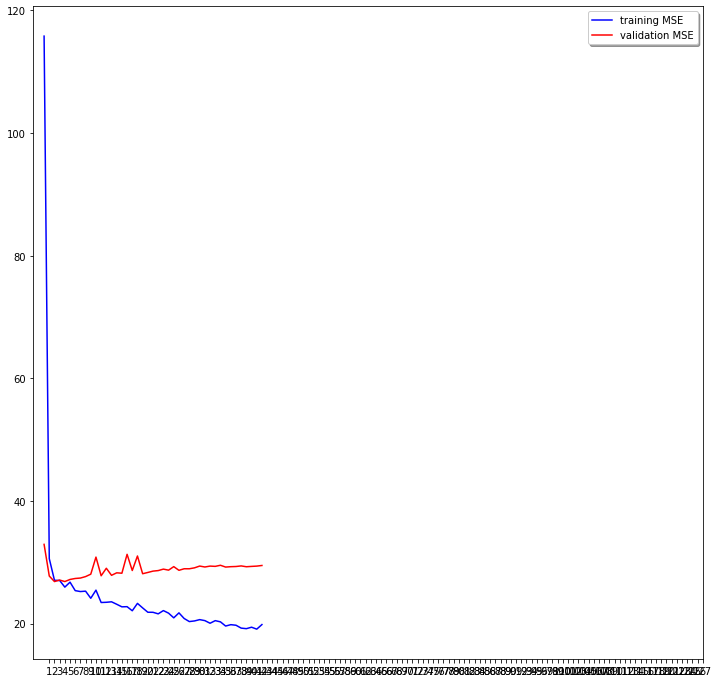

In [21]:
# Melakukan visualisasi nilai MSE pada data training dan testing.
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.plot(history.history['mse'], color='b', label = 'training MSE')
ax.plot(history.history['val_mse'], color='r', label = 'validation MSE')
ax.set_xticks(np.arange(1, epochs, 1))
legend = plt.legend(loc = 'best', shadow = True)
plt.show()

In [22]:
# Menyusun rekam jejak model berdasarkan nilai MSE pada setiap epoch, diurutkan dari yang terbaik.
history_df = pd.DataFrame(history.history).sort_values('val_mse').reset_index()
history_df.rename(columns = {'index': 'epoch'}, inplace = True)
history_df.to_csv('history_{}.csv'.format(codename), index = False)
history_df

,epoch,loss,mse,val_loss,val_mse,lr
0,2,27.084307,27.082504,26.872469,26.870573,0.005670
1,4,25.965786,25.963829,26.873373,26.871393,0.005670
2,3,27.047228,27.045303,27.118832,27.116888,0.005670
3,5,26.776402,26.774364,27.217836,27.215731,0.005670
4,6,25.394421,25.392298,27.374947,27.372801,0.005670
5,7,25.243849,25.241674,27.444736,27.442547,0.005670
6,8,25.308283,25.306061,27.684078,27.681829,0.005670
7,1,30.605490,30.603769,27.773800,27.772064,0.005670
8,11,23.459036,23.456652,27.818270,27.815872,0.002835
9,13,23.572966,23.570528,27.891909,27.889462,0.002835


In [23]:
# Menyimpan nilai prediksi validasi dan testing diurutkan berdasarkan nilai validasi MSE terbaik.
best_valid_preds = pd.DataFrame()
best_test_preds = pd.DataFrame()

for temp_index in list(history_df.iloc[:, 0]):
    temp_df_valid = pd.read_csv('./valid_preds_{}.csv'.format(temp_index))
    temp_df_test = pd.read_csv('./test_preds_{}.csv'.format(temp_index))
    best_valid_preds = pd.concat([best_valid_preds, temp_df_valid], axis = 1, ignore_index = True)
    best_test_preds = pd.concat([best_test_preds, temp_df_test], axis = 1, ignore_index = True)

best_valid_preds.to_csv('valid_preds_{}.csv'.format(codename), index = False)
best_test_preds.to_csv('test_preds_{}.csv'.format(codename), index = False)

In [24]:
# Membuang file yang sudah tidak diperlukan.
for temp_index in list(history_df.iloc[:, 0]):
    os.remove('./valid_preds_{}.csv'.format(temp_index))
    os.remove('./test_preds_{}.csv'.format(temp_index))

In [25]:
# Menampilkan prediksi data validasi diurutkan berdasarkan nilai validasi MSE terbaik.
best_valid_preds

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,26.289328,27.847775,27.951270,28.136000,27.585934,27.379730,27.542408,24.855246,29.138363,29.524760,...,29.898180,30.451815,29.303316,30.234250,29.513197,30.564970,27.346231,27.905235,27.629097,20.717447
1,28.656046,28.869492,29.239060,28.963808,27.378138,27.484016,26.900196,27.597216,27.704662,27.925634,...,27.768934,28.515894,27.350450,28.300050,27.596363,28.492510,26.153399,26.366524,25.869251,27.557161
2,26.551928,26.869795,27.071793,27.786594,26.962480,26.690990,25.387175,25.968920,25.939672,26.254816,...,25.681047,26.450285,25.021520,25.854540,25.568254,26.442984,23.933693,24.186968,24.420372,26.572643
3,24.991003,25.108965,25.568897,25.750336,23.865599,24.358380,23.784033,23.740498,24.689926,24.262910,...,23.507385,23.983870,22.911276,23.691158,23.155167,24.103544,22.530704,21.906345,22.432419,23.045027
4,25.630373,26.467386,27.139978,26.548597,25.542145,25.478910,25.706015,24.386986,25.960735,26.119684,...,26.534510,26.860804,25.727669,26.776579,26.394485,26.698217,24.330880,24.453123,24.296871,20.531654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,25.166170,24.130749,24.985142,24.144693,23.506044,23.164230,22.961088,25.345892,22.802425,22.946135,...,23.689325,23.912598,22.596054,23.757298,23.270433,24.250517,21.094738,21.274591,21.425194,26.611322
457,25.378536,25.481209,26.057112,26.082670,24.690557,24.821490,24.962730,25.055498,25.328115,24.925694,...,25.085830,25.472582,24.151384,24.780073,24.772223,25.252588,23.850443,22.963486,22.967741,24.123014
458,26.824987,27.642612,27.861296,28.468212,26.654413,26.467669,27.253555,25.827322,28.114298,27.701921,...,28.552933,29.192257,27.836695,28.735086,28.377605,28.949272,26.546366,26.287746,25.903399,22.902197
459,25.516218,25.345661,25.905684,25.626260,24.210764,24.764332,24.279436,24.671322,25.783610,26.216950,...,27.568962,27.905691,26.556534,27.840190,27.402216,27.921920,23.861290,24.545803,24.443888,25.816624


In [26]:
# Menampilkan prediksi data testing diurutkan berdasarkan nilai validasi MSE terbaik.
best_test_preds

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,24.763248,25.472006,25.895120,25.504951,25.378044,24.939062,24.189066,24.356873,24.779787,25.207314,...,23.884264,24.675434,23.367365,24.083204,23.456833,24.571740,22.773201,22.838780,23.287376,25.940700
1,27.542997,28.268023,28.266886,27.982456,27.620564,27.364193,28.217050,26.803938,28.180912,28.558092,...,28.818031,29.468788,28.275314,29.179426,28.378897,29.565613,26.933538,27.316801,26.472404,26.259075
2,26.609253,26.727201,27.622810,27.220633,26.190790,26.491024,25.919535,25.269215,26.973705,27.675621,...,28.405407,28.791490,27.497458,28.443201,27.942884,28.846746,24.905685,25.685677,25.712965,25.727130
3,25.960245,25.758175,26.150414,25.934990,25.548695,26.108290,25.814043,25.055452,26.825954,27.122200,...,27.548962,27.874758,26.574425,27.681950,27.160301,28.041866,25.015230,25.505830,24.948660,26.269940
4,26.320919,27.492573,27.863260,27.305971,26.619366,26.409615,26.616655,25.321264,27.016960,27.535034,...,25.952717,26.879803,25.636047,26.181154,25.495443,27.070890,25.669330,24.846035,25.210688,22.389183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,28.779148,28.451363,28.809536,28.565220,27.751923,27.028337,27.844486,27.561398,28.859830,29.255660,...,30.935585,31.069098,29.764563,31.193352,30.725512,31.252403,27.059568,28.342500,27.202517,30.654710
986,27.000145,27.031580,28.154526,28.894787,27.790730,28.620840,27.898886,26.466496,28.976814,29.069150,...,29.697126,30.061451,28.783115,29.920883,29.306305,30.477110,26.427086,27.289360,27.308756,28.204500
987,25.223616,26.354345,26.283224,26.307161,26.158798,26.660583,26.854836,24.817406,27.694683,27.669258,...,28.432547,28.803694,27.627964,28.688486,27.999102,28.833914,26.188139,26.043678,25.938444,21.877134
988,24.625957,24.648960,25.397041,25.531140,24.522270,24.123915,23.677595,24.341074,24.449500,24.630047,...,21.673666,22.851734,22.015278,22.168465,21.150808,22.589926,22.896797,22.140429,22.697466,24.551931


In [27]:
# Menampilkan nilai MSE terbaik pada data validasi.
error = MSE(y_valid, best_valid_preds[0])
print('nilai MSE pada data validasi: ', error)

nilai MSE pada data validasi:  26.87057023827122


In [28]:
# Mencatat waktu berakhirnya keseluruhan program model dan prediksi data.
global_end_time = time.time()

# Menampilkan waktu eksekusi dari keseluruhan program model dan prediksi data.
total_execution_time = datetime.timedelta(seconds = global_end_time - global_start_time)
print("total execution time: %s" % (total_execution_time))

total execution time: 0:15:44.045241
